In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2

In [ ]:
! rm -f /root/.kaggle
! mkdir /root/.kaggle
! ls -al /root/.kaggle
! mv kaggle.json /root/.kaggle

total 12
drwxr-xr-x 2 root root 4096 Feb 11 13:33 .
drwx------ 1 root root 4096 Feb 11 13:33 ..


In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d fusicfenta/chest-xray-for-covid19-detection

 99% 174M/176M [00:01<00:00, 118MB/s]
100% 176M/176M [00:01<00:00, 123MB/s]


In [ ]:
! unzip -q /content/chest-xray-for-covid19-detection.zip

In [ ]:
np.random.choice(os.listdir('/content/Dataset/Train'))

'Normal'

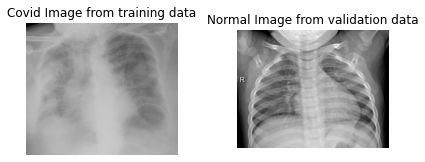

In [ ]:
#viewing random image from training and validation dataset
train_label = np.random.choice(os.listdir('/content/Dataset/Train'))
train_path = 'Dataset/Train/' + train_label + '/'

val_label = np.random.choice(os.listdir('/content/Dataset/Val'))
val_path = 'Dataset/Val/' + val_label + '/'

plt.subplot(121)
img = cv2.imread(train_path + np.random.choice(os.listdir(train_path)))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'{train_label} Image from training data')
plt.axis(False)

plt.subplot(122)
img = cv2.imread(val_path + np.random.choice(os.listdir(val_path)))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'{val_label} Image from validation data')
plt.axis(False);

plt.tight_layout()

In [ ]:
#loading training and validation dataset into memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#will be used to view augmented and unaugmented image
train_datagen = ImageDataGenerator(rescale=1/255.) 

train_data_unaugmented = train_datagen.flow_from_directory('Dataset/Train',target_size=(500, 500),batch_size=32, 
                                    shuffle=True)

#will be used to train the actual data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True # flip the image on the horizontal axis
                                             ) 

train_data = train_datagen_augmented.flow_from_directory('Dataset/Train',target_size=(500, 500),batch_size=32, 
                                    shuffle=True)

val_data = train_datagen_augmented.flow_from_directory('Dataset/Val',target_size=(500, 500),batch_size=32, 
                                    shuffle=True)

Found 288 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


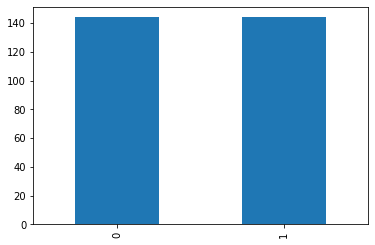

In [ ]:
#labels per class
pd.Series(train_data.labels).value_counts().plot(kind='bar')

In [ ]:
unique_class=list(train_data.class_indices.keys())

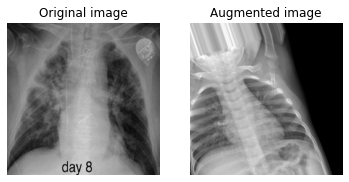

In [ ]:
# Get data batch samples
images, labels = train_data_unaugmented.next()
augmented_images, augmented_labels = train_data.next() # Note: labels aren't augmented, they stay the same

# Show original image and augmented image
random_number = np.random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.subplot(1,2,1)
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

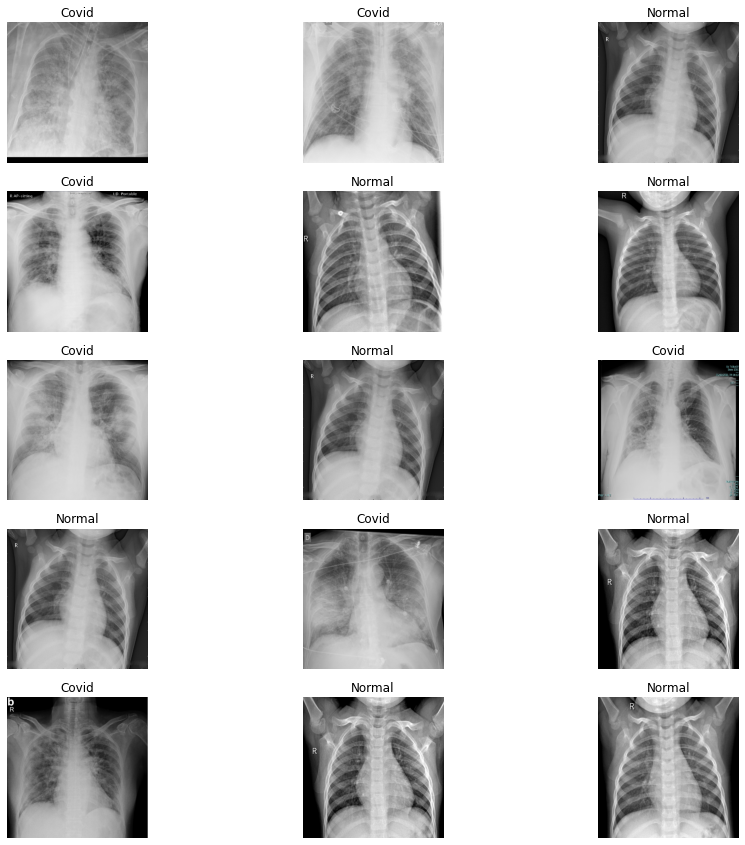

In [ ]:
#visualizing some images from training dataset
img,label = train_data_unaugmented.next()
plt.figure(figsize=(15,15))
for i in range(15):
  plt.subplot(5,3,i+1)
  num = np.random.randint(0,32)#to select random image from batch of 32 images
  plt.imshow(img[num])
  plt.title(unique_class[np.argmax(label[num])])
  plt.axis(False)

In [ ]:
#callback to stop model from training
early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=4)

In [ ]:
vgg_conv_model = tf.keras.applications.VGG16(include_top=False, input_shape=(500, 500, 3))

for layer in vgg_conv_model.layers:
  layer.trainable = False

batch_norm = tf.keras.layers.BatchNormalization(renorm=True)(vgg_conv_model.output)
global_pool = tf.keras.layers.GlobalAveragePooling2D()(batch_norm)
dense1 = tf.keras.layers.Dense(512, activation='relu') (global_pool)
dropout = tf.keras.layers.Dropout(.5)(dense1)
# flatten = tf.keras.layers.Flatten()(vgg_conv_model.output)
dense2 = tf.keras.layers.Dense(64, activation='relu') (dropout)
pred = tf.keras.layers.Dense(2,activation='sigmoid') (dense2)

vgg_model = tf.keras.models.Model(inputs=[vgg_conv_model.input], outputs=[pred])

vgg_model.compile(tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, 
                   metrics = ["acc"])

vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                              

In [ ]:
vgg_model_history=vgg_model.fit(train_data, batch_size=32, epochs=40,validation_data=val_data,callbacks=[early_stopping])

Epoch 1/40
9/9 [==============================] - 67s 5s/step - loss: 0.6662 - acc: 0.6076 - val_loss: 0.5876 - val_acc: 0.7667
Epoch 2/40
9/9 [==============================] - 30s 3s/step - loss: 0.5754 - acc: 0.7604 - val_loss: 0.4362 - val_acc: 0.9500
Epoch 3/40
9/9 [==============================] - 30s 3s/step - loss: 0.4262 - acc: 0.8646 - val_loss: 0.3377 - val_acc: 0.8833
Epoch 4/40
9/9 [==============================] - 29s 3s/step - loss: 0.3122 - acc: 0.8993 - val_loss: 0.2584 - val_acc: 0.9167
Epoch 5/40
9/9 [==============================] - 29s 3s/step - loss: 0.3080 - acc: 0.8681 - val_loss: 0.2649 - val_acc: 0.8667
Epoch 6/40
9/9 [==============================] - 30s 3s/step - loss: 0.2548 - acc: 0.8958 - val_loss: 0.2069 - val_acc: 0.9167
Epoch 7/40
9/9 [==============================] - 29s 3s/step - loss: 0.1989 - acc: 0.9306 - val_loss: 0.2187 - val_acc: 0.9167
Epoch 8/40
9/9 [==============================] - 34s 4s/step - loss: 0.1940 - acc: 0.9167 - val_loss: 0

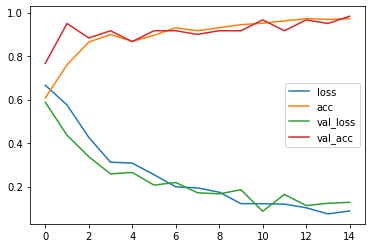

In [ ]:
pd.DataFrame(vgg_model_history.history).plot()

In [ ]:
vgg_model.evaluate(val_data)

2/2 [==============================] - 5s 2s/step - loss: 0.1714 - acc: 0.9667


[0.1713944375514984, 0.9666666388511658]

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##uncomment below if triggering for the first time it will create a 'model' directory which will be used to save the model
# !mkdir /content/gdrive/MyDrive/models

In [ ]:
# vgg_model.save('/content/gdrive/MyDrive/models/vgg_model')

In [ ]:
#loading saved model from above location
loaded_vgg_model = tf.keras.models.load_model('/content/gdrive/MyDrive/models/vgg_model') 

In [ ]:
#validating loaded model again on vadlidation data
loaded_vgg_model.evaluate(val_data)

2/2 [==============================] - 7s 2s/step - loss: 0.1112 - acc: 0.9667


[0.11118459701538086, 0.9666666388511658]

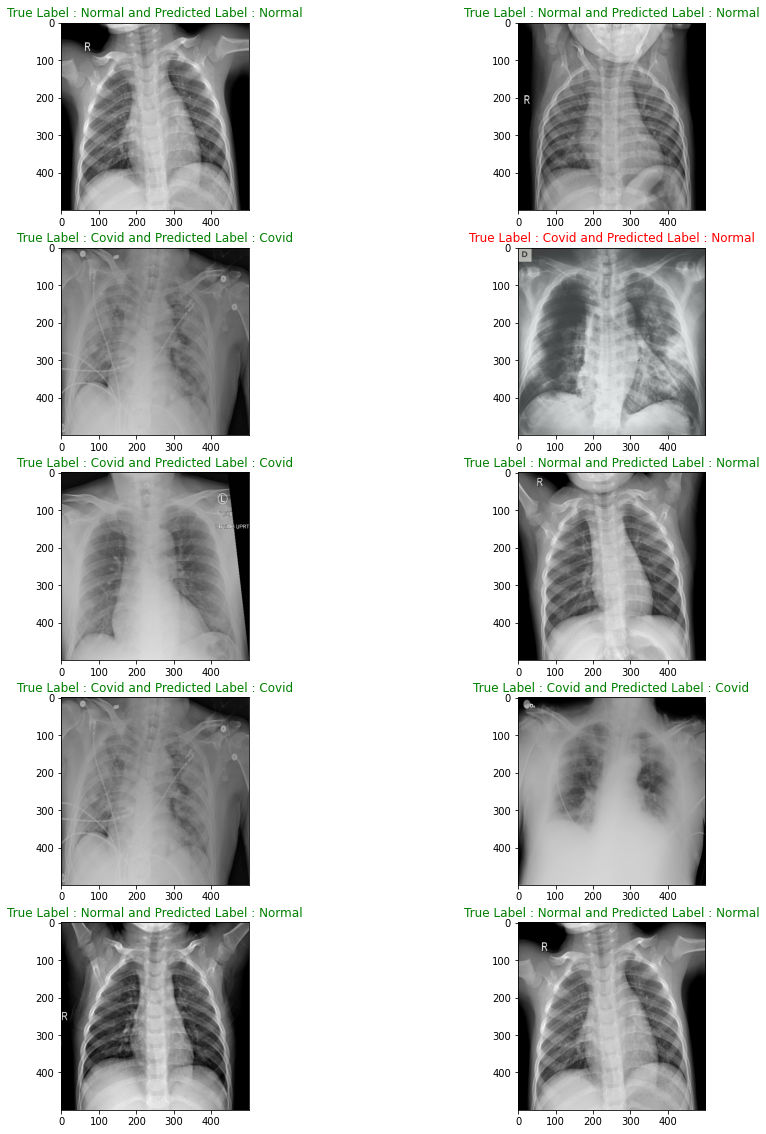

In [ ]:
#taking 10 random images from validation dataset to check true label and predicted label
rand_images_path=np.random.choice(val_data.filenames,10)

#writing a loop to plot and predict on these images
plt.figure(figsize=(15,20))
for i, j in enumerate(rand_images_path):
  true_label = j.split('/')[0]
  plt.subplot(5,2,i+1)
  image_1 = tf.io.read_file('/content/Dataset/Val/'+j)
  image_1 = tf.image.decode_jpeg(image_1, channels=3)
  image = tf.image.resize(image_1, size=[500, 500])
  image = image/255.0
  image = tf.expand_dims(image,axis=0)
  pred = loaded_vgg_model.predict(image,verbose=0)
  predicted_class = unique_class[np.argmax(pred)]
  plt.imshow(image)
  if true_label==predicted_class:
    plt.title(f'True Label : {true_label} and Predicted Label : {predicted_class}',color='g')
  else:
    plt.title(f'True Label : {true_label} and Predicted Label : {predicted_class}',color='r')

In [ ]:
#making a function that can do predictions on any images from web
def pred_and_plot(model, filename, class_names,IMAGE_SHAPE=(500,500)):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img,channels=3)
  img = tf.image.resize(img,IMAGE_SHAPE)
  img = img/255.0

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  # Get the predicted class
  pred_class = class_names[np.argmax(pred)]

  # Plot the image and predicted class
  plt.imshow(img)
  if np.argmax(pred)==0:
    plt.title(f"Covid Positive : Consult Doctor",color='r')
    plt.axis(False);
  elif np.argmax(pred)==1: 
    plt.title(f"Covid Negative : Normal Report",color='g')
    plt.axis(False);

1/1 [==============================] - 0s 27ms/step
[[0.00198091 0.9976895 ]]


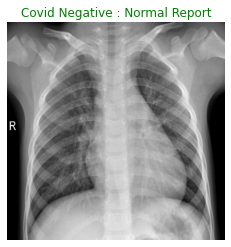

In [ ]:
#making some predictions from above function from Prediction data
pred_and_plot(model=loaded_vgg_model,filename='/content/Dataset/Prediction/NORMAL2-IM-0353-0001.jpeg',class_names=unique_class)

1/1 [==============================] - 0s 25ms/step
[[0.9041658  0.11972504]]


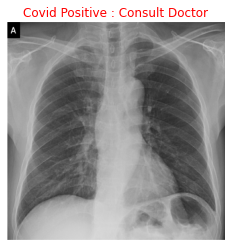

In [ ]:
pred_and_plot(model=loaded_vgg_model,filename='/content/Dataset/Prediction/ryct.2020200034.fig2.jpeg',class_names=unique_class)